# Generates images from text prompts with CLIP guided diffusion.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses either OpenAI's 256x256 unconditional ImageNet or Katherine Crowson's fine-tuned 512x512 diffusion model (https://github.com/openai/guided-diffusion), together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images.

Modified by Daniel Russell (https://github.com/russelldc, https://twitter.com/danielrussruss) to include (hopefully) optimal params for quick generations in 15-100 timesteps rather than 1000, as well as more robust augmentations.

**Update**: Sep 19th 2021


Further improvements from Dango233 and nsheppard helped improve the quality of diffusion in general, and especially so for shorter runs like this notebook aims to achieve.

Katherine's original notebook can be found here:
https://colab.research.google.com/drive/1QBsaDAZv8np29FPbvjffbE1eytoJcsgA

Vark added code to load in multiple Clip models at once, which all prompts are evaluated against, which may greatly improve accuracy.

--

I, Somnai (https://twitter.com/Somnai_dreams), have made the following QoL improvements and assorted implementations:

**Update**: Oct 29th 2021

QoL improvements added by Somnai (@somnai_dreams), including user friendly UI, settings+prompt saving and improved google drive folder organization.

**Update**: Nov 13th 2021

Now includes sizing options, intermediate saves and fixed image prompts and perlin inits. unexposed batch option since it doesn't work

**Update**: Nov 22nd 2021

Initial addition of Katherine Crowson's Secondary Model Method (https://colab.research.google.com/drive/1mpkrhOjoyzPeSWy2r7T8EYRaU7amYOOi#scrollTo=X5gODNAMEUCR)

Noticed settings were saving with the wrong name so corrected it. Let me know if you preferred the old scheme.

#Tutorial

**Diffusion settings**
---

Setting | Description | Default
--- | --- | ---
**Your vision:**
`text_prompts` | A description of what you'd like the machine to generate. Think of it like writing the caption below your image on a website. | N/A
`image_prompts` | Think of these images more as a description of their contents. | N/A
**Image quality:**
`clip_guidance_scale`  | Controls how much the image should look like the prompt. | 1000
`tv_scale` |  Controls the smoothness of the final output. | 150
`range_scale` |  Controls how far out of range RGB values are allowed to be. | 150
`sat_scale` | Controls how much saturation is allowed. From nshepperd's JAX notebook. | 0
`cutn` | Controls how many crops to take from the image. | 16
`cutn_batches` | Accumulate CLIP gradient from multiple batches of cuts  | 2
**Init settings:**
`init_image` |   URL or local path | None
`init_scale` |  This enhances the effect of the init image, a good value is 1000 | 0
`skip_timesteps` |  Controls the starting point along the diffusion timesteps | 0
`perlin_init` |  Option to start with random perlin noise | False
`perlin_mode` |  ('gray', 'color') | 'mixed'
**Advanced:**
`skip_augs` |Controls whether to skip torchvision augmentations | False
`randomize_class` |Controls whether the imagenet class is randomly changed each iteration | True
`clip_denoised` |Determines whether CLIP discriminates a noisy or denoised image | False
`clamp_grad` |Experimental: Using adaptive clip grad in the cond_fn | True
`seed`  | Choose a random seed and print it at end of run for reproduction | random_seed
`fuzzy_prompt` | Controls whether to add multiple noisy prompts to the prompt losses | False
`rand_mag` |Controls the magnitude of the random noise | 0.1
`eta` | DDIM hyperparameter | 0.5

..

**Model settings**
---

Setting | Description | Default
--- | --- | ---
**Diffusion:**
`timestep_respacing`  | Modify this value to decrease the number of timesteps. | ddim100
`diffusion_steps` || 1000
**Diffusion:**
`clip_models`  | Models of CLIP to load. Typically the more, the better but they all come at a hefty VRAM cost. | ViT-B/32, ViT-B/16, RN50x4

# 1. Pre Set Up

In [1]:
#@title 1.1 Check GPU Status
!nvidia-smi

Mon Mar 28 02:09:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      On   | 00000000:06:00.0  On |                  N/A |
| 60%   81C    P2   160W / 250W |   5945MiB / 12288MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
root_path = '/workspace'

import os
from os import path
#Simple create paths taken with modifications from Datamosh's Batch VQGAN+CLIP notebook
def createPath(filepath):
    if path.exists(filepath) == False:
        os.makedirs(filepath)
        print(f'Made {filepath}')
    else:
        print(f'filepath {filepath} exists.')

initDirPath = f'{root_path}/init_images'
createPath(initDirPath)
outDirPath = f'{root_path}/images_out'
createPath(outDirPath)

model_path = '/content/models'
createPath(model_path)

Made /content/init_images
Made /content/images_out
Made /content/models


#2. Install

Run this once at the start of your session and after a restart.

In [5]:
#@title ### 2.1 Install and import dependencies
from dataclasses import dataclass
from functools import partial
import gc
import io
import math
import sys
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')
import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if torch.cuda.get_device_capability(device) == (8,0): ## A100 fix thanks to Emad
    print('Disabling CUDNN for A100 gpu', file=sys.stderr)
    torch.backends.cudnn.enabled = False

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'guided-diffusion' already exists and is not an empty directory.
Obtaining file:///workspace/CLIP
  Preparing metadata (setup.py) ... done
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Uninstalling clip-1.0:
      Successfully uninstalled clip-1.0
  Running setup.py develop for clip
Obtaining file:///workspace/guided-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Uninstalling guided-diffusion-0.0.0:
      Successfully uninstalled guided-diffusion-0.0.0
  Running setup.py develop for guided-diffusion
Using device: cuda:0


In [6]:
#@title 2.2 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869


def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(cutn):
            if ch > cutn - cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])


def do_run():
    loss_values = []
 
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
 
    target_embeds, weights = [], []
    model_stats = []
    
    for clip_model in clip_models:
        model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
        model_stat["clip_model"] = clip_model
        model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs)

        for prompt in text_prompts:
            txt, weight = parse_prompt(prompt)
            txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

            if fuzzy_prompt:
                for i in range(25):
                    model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * rand_mag).clamp(0,1))
                    model_stat["weights"].append(weight)
            else:
                model_stat["target_embeds"].append(txt)
                model_stat["weights"].append(weight)
    
        for prompt in image_prompts:
            path, weight = parse_prompt(prompt)
            img = Image.open(fetch(path)).convert('RGB')
            img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
            batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
            embed = clip_model.encode_image(normalize(batch)).float()
            if fuzzy_prompt:
                for i in range(25):
                    model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                    weights.extend([weight / cutn] * cutn)
            else:
                model_stat["target_embeds"].append(embed)
                model_stat["weights"].extend([weight / cutn] * cutn)
    
        model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
        model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
        if model_stat["weights"].sum().abs() < 1e-3:
            raise RuntimeError('The weights must not sum to 0.')
        model_stat["weights"] /= model_stat["weights"].sum().abs()
        model_stats.append(model_stat)
 
    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)
    
    if perlin_init:
        if perlin_mode == 'color':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
        elif perlin_mode == 'gray':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        else:
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
        
        # init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
        init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
        del init2
 
    cur_t = None
 
    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x = x.detach().requires_grad_()
            n = x.shape[0]
            if use_secondary_model is True:
                alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                cosine_t = alpha_sigma_to_t(alpha, sigma)
                out = secondary_model(x, cosine_t[None].repeat([n])).pred
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
            else:
                my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out['pred_xstart'] * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
            for model_stat in model_stats:
                for i in range(cutn_batches):
                    clip_in = normalize(model_stat["make_cutouts"](x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([cutn, n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
            tv_losses = tv_loss(x_in)
            if use_secondary_model is True:
                range_losses = range_loss(out)
            else:
                range_losses = range_loss(out['pred_xstart'])
            sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
            loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
            if init is not None and init_scale:
                init_losses = lpips_model(x_in, init)
                loss = loss + init_losses.sum() * init_scale
            x_in_grad += torch.autograd.grad(loss, x_in)[0]
            grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
        if clamp_grad:
            magnitude = grad.square().mean().sqrt()
            return grad * magnitude.clamp(max=0.05) / magnitude
        return grad
 
    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive
 
    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1
        total_steps = cur_t
 
        if model_config['timestep_respacing'].startswith('ddim'):
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
                eta=eta,
            )
        else:
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
            )

        for j, sample in enumerate(samples):
            display.clear_output(wait=True)
            cur_t -= 1
            intermediateStep = False
            if steps_per_checkpoint is not None:
                if j % steps_per_checkpoint == 0 and j > 0:
                    intermediateStep = True
            elif j in intermediate_saves:
                intermediateStep = True
            if j % display_rate == 0 or cur_t == -1 or intermediateStep == True:
                for k, image in enumerate(sample['pred_xstart']):
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                    percent = math.ceil(j/total_steps*100)
                    if n_batches > 0:
                        #if intermediates are saved to the subfolder, don't append a step or percentage to the name
                        if cur_t == -1 and intermediates_in_subfolder is True:
                            filename = f'{batch_name}({batchNum})_{i:04}.png'
                        else:
                            #If we're working with percentages, append it
                            if steps_per_checkpoint is not None:
                                filename = f'{batch_name}({batchNum})_{i:04}-{percent:02}%.png'
                            # Or else, iIf we're working with specific steps, append those
                            else:
                                filename = f'{batch_name}({batchNum})_{i:04}-{j:03}.png'
                    image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                    image.save('progress.png')
                    display.display(display.Image('progress.png'))
                    if steps_per_checkpoint is not None:
                        if j % steps_per_checkpoint == 0 and j > 0:
                            if intermediates_in_subfolder is True:
                                image.save(f'{partialFolder}/{filename}')
                            else:
                                image.save(f'{batchFolder}/{filename}')
                    else:
                        if j in intermediate_saves:
                            if intermediates_in_subfolder is True:
                                image.save(f'{partialFolder}/{filename}')
                            else:
                                image.save(f'{batchFolder}/{filename}')
                    if cur_t == -1:
                        if i == 0:
                            save_settings()
                        image.save(f'{batchFolder}/{filename}')
 
        plt.plot(np.array(loss_values), 'r')

def save_settings():
    setting_list = {
        'text_prompts': text_prompts,
        'image_prompts': image_prompts,
        'clip_guidance_scale': clip_guidance_scale,
        'tv_scale': tv_scale,
        'range_scale': range_scale,
        'sat_scale': sat_scale,
        'cutn': cutn,
        'cutn_batches': cutn_batches,
        'init_image': init_image,
        'init_scale': init_scale,
        'skip_timesteps': skip_timesteps,
        'perlin_init': perlin_init,
        'perlin_mode': perlin_mode,
        'skip_augs': skip_augs,
        'randomize_class': randomize_class,
        'clip_denoised': clip_denoised,
        'clamp_grad': clamp_grad,
        'seed': seed,
        'fuzzy_prompt': fuzzy_prompt,
        'rand_mag': rand_mag,
        'eta': eta,
        'width': width,
        'height': height,
        'diffusion_model': diffusion_model,
        'use_secondary_model': use_secondary_model,
        'timestep_respacing': timestep_respacing,
        'timestep_respacing': timestep_respacing,
        'diffusion_steps': diffusion_steps,
        'ViTB32': ViTB32,
        'ViTB16': ViTB16,
        'RN101': RN101,
        'RN50': RN50,
        'RN50x4': RN50x4,
        'RN50x16': RN50x16,
    }
    print('Settings:', setting_list)
    with open(f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+") as f:   #save settings
        json.dump(setting_list, f, ensure_ascii=False, indent=4)
  

In [7]:
#@title 2.3 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


# 3. Diffusion and CLIP model settings

In [8]:
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100"]


if diffusion_model == '256x256_diffusion_uncond':
    !wget --continue 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt' -P {model_path}
elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    !wget --continue 'http://batbot.tv/ai/models/guided-diffusion/512x512_diffusion_uncond_finetune_008100.pt' -P {model_path}

use_secondary_model = True #@param {type: 'boolean'}

# Download the secondary diffusion model v2
# SHA-256: 983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a 
if use_secondary_model == True:
    !wget --continue  'https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth' -P {model_path}


timestep_respacing = 'ddim250' #@param ['25','50','100','150','250','500','1000','ddim25','ddim50', 'ddim75', 'ddim100','ddim150','ddim250','ddim500','ddim1000']  
diffusion_steps = 1000 #@param {type: 'number'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = False #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
# ViTL = True #@param{type:"boolean"}
#@markdown *RN50x16 for A100 only*


model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

secondary_model_ver = 2
model_default = model_config['image_size']

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

if secondary_model_ver == 2:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32 is True: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)) 
if ViTB16 is True: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device) ) 
if RN50 is True: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4 is True: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN50x16 is True: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN101 is True: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device)) 
# if ViTL is True: clip_models.append(load('ViT-L', jit=False)[0].eval().requires_grad_(False).to(device)) 

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

--2022-03-28 02:15:04--  http://batbot.tv/ai/models/guided-diffusion/512x512_diffusion_uncond_finetune_008100.pt
Resolving batbot.tv (batbot.tv)... 62.212.86.148
Connecting to batbot.tv (batbot.tv)|62.212.86.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2232025447 (2.1G) [application/octet-stream]
Saving to: ‘/content/512x512_diffusion_uncond_finetune_008100.pt’

512x512_diffusion_u 100%[===================>]   2.08G  5.82MB/s    in 5m 46s  

2022-03-28 02:20:50 (6.16 MB/s) - ‘/content/512x512_diffusion_uncond_finetune_008100.pt’ saved [2232025447/2232025447]

--2022-03-28 02:20:51--  https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth
Resolving v-diffusion.s3.us-west-2.amazonaws.com (v-diffusion.s3.us-west-2.amazonaws.com)... 52.218.136.25
Connecting to v-diffusion.s3.us-west-2.amazonaws.com (v-diffusion.s3.us-west-2.amazonaws.com)|52.218.136.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55380626 (

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.3MiB/s]
100%|███████████████████████████████████████| 335M/335M [00:26<00:00, 13.2MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /workspace/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.9MB/s] 


Loading model from: /opt/conda/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


# 4. Settings

In [9]:
#@markdown ####**Basic Settings:**

clip_guidance_scale = 5000 #@param{type: 'number'}
tv_scale =  8000#@param{type: 'number'}
range_scale = 150  #@param{type: 'number'}
sat_scale = 0  #@param{type: 'number'}
cutn = 16  #@param{type: 'number'}
cutn_batches = 2  #@param{type: 'number'}

init_image = '' #@param{type: 'string'}
init_scale =   200#@param{type: 'number'}
skip_timesteps = 0  #@param{type: 'number'}

#@markdown Size must be multiple of 64. Leave as `model_default` for default sizes. 
width = model_default#@param{type: 'raw'}
height = model_default#@param{type: 'raw'}

#@markdown ---

#@markdown ####**Saving:**
batch_name = 'Test' #@param{type: 'string'}
intermediate_saves =  5#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}
#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps 

#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.

#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)



#@markdown ---

#@markdown ####**Advanced Settings:**
#@markdown *Perlin init will replace your init, so uncheck if using one.*

perlin_init = True  #@param{type: 'boolean'}
perlin_mode = 'mixed' 

skip_augs = False #@param{type: 'boolean'}
randomize_class = True #@param{type: 'boolean'}
clip_denoised = False #@param{type: 'boolean'}
clamp_grad = True #@param{type: 'boolean'}

seed = 'random_seed' #@param{type: 'string'}

fuzzy_prompt = False #@param{type: 'boolean'}
rand_mag = 0.05  #@param{type: 'number'}
eta =   1#@param{type: 'number'}

if type(intermediate_saves) is not list:
    steps_per_checkpoint = math.floor((diffusion.num_timesteps - skip_timesteps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
else:
    steps_per_checkpoint = None


if init_image == '':
    init_image = None

side_x = width;
side_y = height;

#Make folder for batch
batchFolder = f'{outDirPath}/{batch_name}'
createPath(batchFolder)

partialFolder = f'{batchFolder}/partials'
createPath(partialFolder)

Will save every 41 steps
Made /content/images_out/Test
Made /content/images_out/Test/partials


##Prompts

In [10]:
text_prompts = [
    "A lost treasure found in the depths of atlantis by greg ruktowski, trending on artstation",
]

image_prompts = [ 
    # 'mona.jpg',
]

# 5. Diffuse!

100%|█████████▉| 249/250 [03:25<00:00,  1.22it/s]

Batch 4, step 249, output 0:


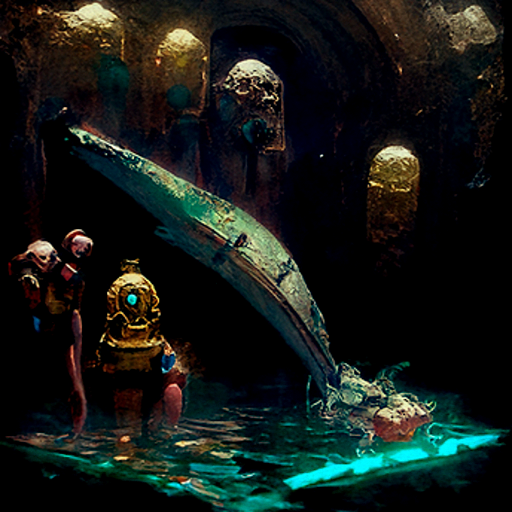

100%|██████████| 250/250 [03:25<00:00,  1.22it/s]

seed 3336856935


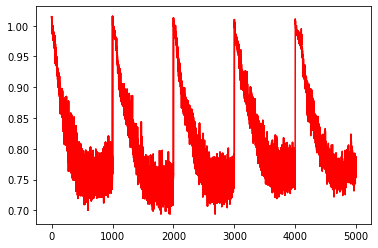

In [11]:
#@title Do the Run!

display_rate = 2 #@param{type: 'number'}
n_batches =  5#@param{type: 'number'}
batch_size = 1 

batchNum = len(glob(batchFolder+"/*.txt"))

while path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

if seed == 'random_seed':
    seed = random.randint(0, 2**32)
else:
    seed = int(seed)

gc.collect()
torch.cuda.empty_cache()
try:    
    do_run()
except KeyboardInterrupt:
    pass
finally:
    print('seed', seed)
    gc.collect()
    torch.cuda.empty_cache()